This notebook aims to combine all necessary steps for each model of the combinations of all other ML models.

In [1]:
# first import the libraries
import pandas as pd
import numpy as np
from darts import TimeSeries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from darts.models import LinearRegressionModel, RegressionModel, RandomForest, RegressionEnsembleModel
from sklearn import cross_decomposition
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from darts.metrics import mape, r2_score, mse, mae
import sklearn
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, plotting, EfficientFrontier
import copy


import warnings

In [2]:
# Filter out the FutureWarning message
warnings.filterwarnings("ignore", category=(FutureWarning))
warnings.filterwarnings("ignore", category=(UserWarning))

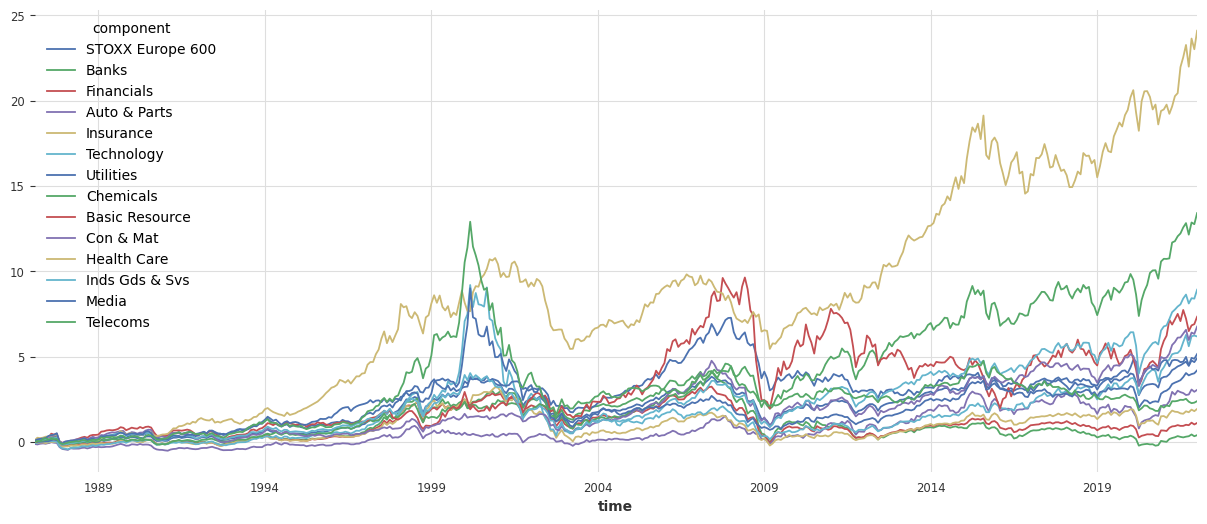

In [3]:
# load the data, use Darts TimeSeries
ts = TimeSeries.from_csv('data/price_data_filtered.csv', parse_dates=True, index_col=0)
# compute monthly returns using pandas pct_change
returns = ts.pd_dataframe().pct_change().dropna()
# compute the cumulative monthly returns
cum_returns = (1 + returns).cumprod() - 1

cum_returns_portfolio = cum_returns

# plot the cumulative returns
fig, ax = plt.subplots(figsize=(15, 6))
cum_returns.plot(ax=ax);
# to use the Darts models, we need to convert the data to a Darts TimeSeries
cum_returns = TimeSeries.from_dataframe(df = cum_returns,time_col= 0, fill_missing_dates=True)
# split the data into training and test set, use 80% for training
train, test = cum_returns.split_after(0.8)

## Benchmark Portfolios

### Equal Weighted Portfolio

In [4]:
# create a list of the column names
col_list = list(cum_returns.columns)[1:]

# create weights
weights_ew = 1/len(col_list)

# print single weight and the sum of all weights
print('The weight for each stock is: ' + str(weights_ew))
print('The sum of all weights is: ' + str(weights_ew * 13))

# create a new column in cum_returns for the equal weighted portfolio
cum_returns_portfolio['equal_weighted'] = cum_returns_portfolio[col_list].mul(weights_ew).sum(axis=1)

# create a new variable called portfolio_returns with same structure as cum_returns
portfolio_returns = cum_returns_portfolio.copy()
# delete all columns except for the equal_weighted column
portfolio_returns.drop(cum_returns_portfolio.columns.difference(['equal_weighted']), 1, inplace=True)
portfolio_returns.tail()

# delete equal weighted column from cum_returns
cum_returns_portfolio.drop('equal_weighted', axis=1, inplace=True)

The weight for each stock is: 0.07692307692307693
The sum of all weights is: 1.0


### Portfolio based on Historical Average

In [5]:
# Calculate average daily returns for each stock and exlude the first column
avg_returns = cum_returns_portfolio.mean()[1:]

# Calculate weights based on average daily returns
weights_ha = avg_returns / avg_returns.sum()

# Calculate portfolio returns
ha_returns = (cum_returns_portfolio * weights_ha).sum(axis=1)

# Add portfolio_returns as a new column in cum_returns
portfolio_returns['historical_average'] = ha_returns

# print single weight and the sum of all weights for historical average portfolio
print('The weight for each stock is: ' + str(weights_ha))
print('The sum of all weights is: ' + str(weights_ha.sum()))

The weight for each stock is: component
Banks             0.033024
Financials        0.030685
Auto & Parts      0.021829
Insurance         0.027747
Technology        0.050778
Utilities         0.085845
Chemicals         0.108597
Basic Resource    0.099537
Con & Mat         0.061754
Health Care       0.258600
Inds Gds & Svs    0.076979
Media             0.063096
Telecoms          0.081530
dtype: float64
The sum of all weights is: 1.0


#### Import all models retrieved

In [6]:
# import the data of shrinkage, dimred and nonlinear as a dataframe
shrinkage = pd.read_csv('data/portfolio_returns_shrinkage.csv', index_col=0, parse_dates=True)
dimred = pd.read_csv('data/portfolio_returns_dimred.csv', index_col=0, parse_dates=True)
nonlinear = pd.read_csv('data/portfolio_returns_nonlinearML.csv', index_col=0, parse_dates=True)

In [7]:
# drop equal weighted column and historical average column from dim_red
#shrinkage.drop(['equal_weighted', 'historical_average'], axis=1, inplace=True)
dimred.drop(['equal_weighted', 'historical_average'], axis=1, inplace=True)
nonlinear.drop(['equal_weighted', 'historical_average'], axis=1, inplace=True)

In [8]:
# combine the dataframes
portfolio_returns = pd.concat([shrinkage, dimred, nonlinear], axis=1)

In [9]:
# create model dataframe that drops the equal weighted and historical average columns
model = portfolio_returns.drop(['equal_weighted', 'historical_average'], axis=1)

In [10]:
"""# save this as a csv file
portfolio_returns.to_csv('data/portfolio_returns_combination.csv', index=True, header=True)
model.to_csv('data/model.csv', index=True, header=True)
# import this csv file as a darts time series
portfolio_returns = TimeSeries.from_csv('data/portfolio_returns_combination.csv', index_col=0, parse_dates=True)
model = TimeSeries.from_csv('data/model.csv', index_col=0, parse_dates=True)"""

"# save this as a csv file\nportfolio_returns.to_csv('data/portfolio_returns_combination.csv', index=True, header=True)\nmodel.to_csv('data/model.csv', index=True, header=True)\n# import this csv file as a darts time series\nportfolio_returns = TimeSeries.from_csv('data/portfolio_returns_combination.csv', index_col=0, parse_dates=True)\nmodel = TimeSeries.from_csv('data/model.csv', index_col=0, parse_dates=True)"

### Mean Combination

In [11]:
col_list_model = list(model.columns)

In [12]:
# create weights
weights_ew_models = 1/len(col_list_model)

# print the single weight and the sum of all weights
print('The single weight is: ', weights_ew_models)
print('The sum of all weights is: ', weights_ew_models*len(col_list_model))

The single weight is:  0.07142857142857142
The sum of all weights is:  1.0


In [13]:
# create a new csv file for the combination_returns
combination_returns = pd.DataFrame()

In [14]:
# create a new column for the equal weighted combination portfolio
combination_returns['MC_ML'] = model.mul(weights_ew_models).sum(axis=1)

In [15]:
print('The Return of the Mean Combination of all ML Models is: ' + str(round(combination_returns['MC_ML'].iloc[-1], 2)) + '%')

The Return of the Mean Combination of all ML Models is: 16.36%


### Trimmed Mean Combination

In [16]:
# which model has the highest return?
print('The model with the highest return is: ' + str(model.idxmax(axis=1).iloc[-1]))

# which model has the lowest return?
print('The model with the lowest return is: ' + str(model.idxmin(axis=1).iloc[-1]))

The model with the highest return is: ridge_regression_1
The model with the lowest return is: pls_regression_1


In [50]:
# create col-list without these 2 models
col_list_trim = col_list_model.copy()
col_list_trim.remove('ridge_regression_1')
col_list_trim.remove('pls_regression_1')

In [51]:
# create weights
weights_trim = 1/len(col_list_trim)

# print the single weight and the sum of all weights
print('The single weight is: ', weights_trim)
print('The sum of all weights is: ', weights_trim*len(col_list_trim))

The single weight is:  0.08333333333333333
The sum of all weights is:  1.0


In [52]:
# create a new column for the trimmed mean combination portfolio
combination_returns['TMC_ML'] = model[col_list_trim].mul(weights_trim).sum(axis=1)

In [53]:
print('The Return of the Trimmed Mean Combination of all ML Models is: ' + str(round(combination_returns['TMC_ML'].iloc[-1], 2)) + '%')

The Return of the Trimmed Mean Combination of all ML Models is: 16.56%


### Weights based on MSE ranking
$$
\omega_{i, t}=\mathrm{RANK}_{i, t}^{-1} / \sum_{i=1}^m \mathrm{RANK}_{i, t}^{-1}
$$

In [54]:
# import all evaluation metrics
ev_shrinkage = pd.read_csv('data/evaluation_shrinkage.csv', index_col=0, parse_dates=True)
ev_dimred = pd.read_csv('data/evaluation_dimred.csv', index_col=0, parse_dates=True)
ev_nonlinear = pd.read_csv('data/evaluation_nonlinear.csv', index_col=0, parse_dates=True)

#ev_dimred = ev_dimred / 100

In [55]:
# create dictionary with all evaluation metrics
evaluation = {
    'Portfolio': [
        'Linear Regression',
        'Ridge Regression',
        'Lasso Regression',
        'Bayesian Regression',
        'PLS Regression',
        'Canonical PLS Regression',
        'CCA Regression',
        'Random Forest',
        'Gradient Boosting',
        'Ada Boosting',
        'Extra Trees',
        'Epsilon-Support Vector Regression',
        'Nu-Support Vector Regression',
        'MLP with 3 Layers'
    ],
    'MSE': [
            ev_shrinkage['MSE'][0],
             ev_shrinkage['MSE'][1],
            ev_shrinkage['MSE'][2],
            ev_shrinkage['MSE'][3],
            ev_dimred['MSE'][0],
            ev_dimred['MSE'][1],
            ev_dimred['MSE'][2],
            ev_nonlinear['MSE'][0],
            ev_nonlinear['MSE'][1],
            ev_nonlinear['MSE'][2],
            ev_nonlinear['MSE'][3],
            ev_nonlinear['MSE'][4],
            ev_nonlinear['MSE'][5],
            ev_nonlinear['MSE'][6]
    ],
    'MAPE': [
            ev_shrinkage['MAPE'][0],
            ev_shrinkage['MAPE'][1],
            ev_shrinkage['MAPE'][2],
            ev_shrinkage['MAPE'][3],
            ev_dimred['MAPE'][0],
            ev_dimred['MAPE'][1],
            ev_dimred['MAPE'][2],
            ev_nonlinear['MAPE'][0],
            ev_nonlinear['MAPE'][1],
            ev_nonlinear['MAPE'][2],
            ev_nonlinear['MAPE'][3],
            ev_nonlinear['MAPE'][4],
            ev_nonlinear['MAPE'][5],
            ev_nonlinear['MAPE'][6]
    ],
    'MAE': [
            ev_shrinkage['MAE'][0],
            ev_shrinkage['MAE'][1],
            ev_shrinkage['MAE'][2],
            ev_shrinkage['MAE'][3],
            ev_dimred['MAE'][0],
            ev_dimred['MAE'][1],
            ev_dimred['MAE'][2],
            ev_nonlinear['MAE'][0],
            ev_nonlinear['MAE'][1],
            ev_nonlinear['MAE'][2],
            ev_nonlinear['MAE'][3],
            ev_nonlinear['MAE'][4],
            ev_nonlinear['MAE'][5],
            ev_nonlinear['MAE'][6]
    ],
    'R2': [
            ev_shrinkage['R2'][0],
            ev_shrinkage['R2'][1],
            ev_shrinkage['R2'][2],
            ev_shrinkage['R2'][3],
            ev_dimred['R2'][0],
            ev_dimred['R2'][1],
            ev_dimred['R2'][2],
            ev_nonlinear['R2'][0],
            ev_nonlinear['R2'][1],
            ev_nonlinear['R2'][2],
            ev_nonlinear['R2'][3],
            ev_nonlinear['R2'][4],
            ev_nonlinear['R2'][5],
            ev_nonlinear['R2'][6]
    ]
}

In [56]:
# create a dataframe from the dictionary
evaluation = pd.DataFrame(evaluation)

# set the index to the portfolio names
evaluation.set_index('Portfolio', inplace=True)

# divide the vlues by 100 to get percentages
#evaluation[['MAPE', 'MSE', 'MAE', 'R2']] = evaluation[['MAPE', 'MSE', 'MAE', 'R2']].div(100)

# format the dataframe to display the values as percentages
evaluation.style.format("{:.2%}", subset=['MAPE', 'MSE', 'MAE', 'R2'])

,MSE,MAPE,MAE,R2
Portfolio,,,,
Linear Regression,0.11%,18.71%,0.22%,0.92%
Ridge Regression,0.10%,11.64%,0.21%,0.93%
Lasso Regression,0.11%,15.25%,0.22%,0.93%
Bayesian Regression,0.10%,12.03%,0.21%,0.93%
PLS Regression,0.26%,17.49%,0.32%,0.85%
Canonical PLS Regression,0.10%,8.29%,0.20%,0.92%
CCA Regression,0.22%,12.12%,0.30%,0.87%
Random Forest,0.20%,13.01%,0.29%,0.79%
Gradient Boosting,0.18%,18.95%,0.27%,0.88%


In [57]:
# show portfolio with lowest MSE
print('The portfolio with the lowest MSE is: ' + str(evaluation['MSE'].idxmin()))
# show portfolio with lowest MAPE
print('The portfolio with the lowest MAPE is: ' + str(evaluation['MAPE'].idxmin()))
# show portfolio with lowest MAE
print('The portfolio with the lowest MAE is: ' + str(evaluation['MAE'].idxmin()))
# show portfolio with highest R2
print('The portfolio with the highest R2 is: ' + str(evaluation['R2'].idxmax()))

The portfolio with the lowest MSE is: Canonical PLS Regression
The portfolio with the lowest MAPE is: Canonical PLS Regression
The portfolio with the lowest MAE is: Canonical PLS Regression
The portfolio with the highest R2 is: Ridge Regression


In [83]:
# show the 3 best portfolios
sorted_evaluation = evaluation.sort_values(by=['MSE', 'MAE', 'R2', 'MAPE'], ascending=[True, True, False, True]).head(3)
#format the dataframe to display the values as percentages
sorted_evaluation.style.format("{:.2%}", subset=['MAPE', 'MSE', 'MAE', 'R2'])

,MSE,MAPE,MAE,R2
Portfolio,,,,
Canonical PLS Regression,0.10%,8.29%,0.20%,0.92%
Ridge Regression,0.10%,11.64%,0.21%,0.93%
Bayesian Regression,0.10%,12.03%,0.21%,0.93%


In [59]:
# create dataframe with all evaluation metrics
mse_df = pd.DataFrame(evaluation['MSE'])

# set the index to the portfolio
#mse_df.set_index('Portfolio', inplace=True)

# create a second column that asign a rank according to the MSE
mse_df['Rank'] = mse_df['MSE'].rank()

# format the dataframe such that the rank is an integer
mse_df.style.format({'MSE': '{:.2%}', 'Rank': '{:.0f}'})


,MSE,Rank
Portfolio,,
Linear Regression,0.11%,5
Ridge Regression,0.10%,2
Lasso Regression,0.11%,4
Bayesian Regression,0.10%,3
PLS Regression,0.26%,12
Canonical PLS Regression,0.10%,1
CCA Regression,0.22%,11
Random Forest,0.20%,10
Gradient Boosting,0.18%,9


In [60]:
# sum of all ranks
mse_df['Rank'].sum()

105.0

In [61]:
# compute the weights
# the weight followings the formula: rank/sum of all ranks

# create a new column for the weights such that the smallest rank has the highest weight
# compute the inverse of the rank
mse_df['Inverse_Rank'] = 1/mse_df['Rank']
mse_df['Weight'] = mse_df['Inverse_Rank']/mse_df['Inverse_Rank'].sum()

# print the dataframe
mse_df.style.format({'MSE': '{:.2%}', 'Rank': '{:.0f}', 'Weight': '{:.3%}'})

,MSE,Rank,Inverse_Rank,Weight
Portfolio,,,,
Linear Regression,0.11%,5,0.200000,6.151%
Ridge Regression,0.10%,2,0.500000,15.377%
Lasso Regression,0.11%,4,0.250000,7.689%
Bayesian Regression,0.10%,3,0.333333,10.251%
PLS Regression,0.26%,12,0.083333,2.563%
Canonical PLS Regression,0.10%,1,1.000000,30.754%
CCA Regression,0.22%,11,0.090909,2.796%
Random Forest,0.20%,10,0.100000,3.075%
Gradient Boosting,0.18%,9,0.111111,3.417%


In [62]:
# sum of the weight column
mse_df['Weight'].sum()

1.0

In [63]:
#multiply the returns of each model with the corresponding weight
# create a new dataframe
model_weighted = model.copy()

# multiply each column with the corresponding weight
for i in range(len(mse_df)):
    model_weighted.iloc[:, i] = model_weighted.iloc[:, i].mul(mse_df['Weight'][i])

# create a new column for the weighted mean combination portfolio
combination_returns['WMC_ML'] = model_weighted.sum(axis=1)

print('The Return of the Weighted average of ML forecasts based on MSE ranking is: ' + str(round(combination_returns['WMC_ML'].iloc[-1], 2)) + '%')

# import the evaluation metrics for the equal weighted combination portfolio

The Return of the Weighted average of ML forecasts based on MSE ranking is: 16.16%


### Cluster 2 & 3

In [64]:
# clustering into 2 and 3 clusters
cluster_2 = int(len(model.columns) / 2)
cluster_3 = int(len(model.columns) / 3)

In [65]:
print('The number of models for 2 clusters is: ' + str(cluster_2))
print('The number of models for 3 clusters is: ' + str(cluster_3))

The number of models for 2 clusters is: 7
The number of models for 3 clusters is: 4


#### CL2

In [66]:
# sort all mse_df by rank
mse_df.sort_values(by=['Rank'], inplace=True)
mse_df

,MSE,Rank,Inverse_Rank,Weight
Portfolio,,,,
Canonical PLS Regression,0.000972,1.0,1.000000,0.307544
Ridge Regression,0.001018,2.0,0.500000,0.153772
Bayesian Regression,0.001021,3.0,0.333333,0.102515
Lasso Regression,0.001050,4.0,0.250000,0.076886
Linear Regression,0.001076,5.0,0.200000,0.061509
MLP with 3 Layers,0.001193,6.0,0.166667,0.051257
Nu-Support Vector Regression,0.001523,7.0,0.142857,0.043935
Ada Boosting,0.001637,8.0,0.125000,0.038443
Gradient Boosting,0.001827,9.0,0.111111,0.034172


In [67]:
# get the 5 models with the lowest rank according to the mse_df

cl2 = mse_df.sort_values(by=['Rank']).head(cluster_2).index

In [68]:
print(cl2)

Index(['Canonical PLS Regression', 'Ridge Regression', 'Bayesian Regression',
       'Lasso Regression', 'Linear Regression', 'MLP with 3 Layers',
       'Nu-Support Vector Regression'],
      dtype='object', name='Portfolio')


In [69]:
cl2 = ['Bayesian Regression', 'canonical_pls_1', 'ridge_regression_1', 'lasso_regression_1', 'nu_svm', 'linear_regression_1', 'MLP3']

In [70]:
# For CL2:
combination_returns['CL2'] = model[cl2].mean(axis=1)


In [71]:
print('The Return of the Cluster 2 Combination of all ML Models is: ' + str(round(combination_returns['CL2'].iloc[-1], 2)) + '%')

The Return of the Cluster 2 Combination of all ML Models is: 19.04%


#### CL3

In [72]:
cl3 = mse_df.sort_values(by=['Rank']).head(cluster_3).index

In [73]:
print(cl3)

Index(['Canonical PLS Regression', 'Ridge Regression', 'Bayesian Regression',
       'Lasso Regression'],
      dtype='object', name='Portfolio')


In [74]:
cl3 = ['Bayesian Regression', 'canonical_pls_1', 'ridge_regression_1', 'lasso_regression_1']

In [75]:
# For CL3:
combination_returns['CL3'] = model[cl3].mean(axis=1)

In [76]:
print('The Return of the Cluster 3 Combination of all ML Models is: ' + str(round(combination_returns['CL3'].iloc[-1], 2)) + '%')

The Return of the Cluster 3 Combination of all ML Models is: 19.49%


# Analysis Combination Methods

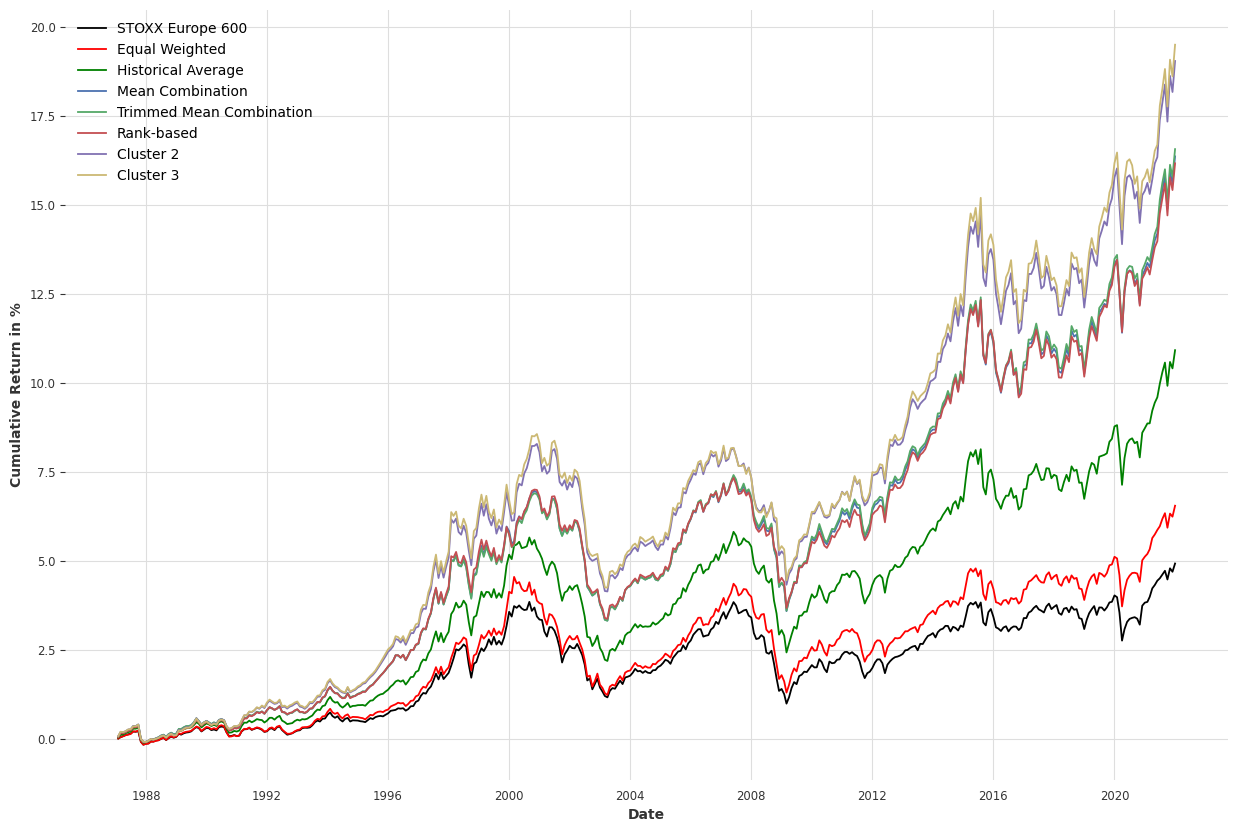

In [77]:
# plot all the cumulative returns
plt.figure(figsize=(15, 10))

plt.plot(cum_returns_portfolio['STOXX Europe 600'], color= 'black', label='STOXX Europe 600')
plt.plot(portfolio_returns['equal_weighted'], color= 'red', label='Equal Weighted')
plt.plot(portfolio_returns['historical_average'], color= 'green', label='Historical Average')
plt.plot(combination_returns['MC_ML'], label='Mean Combination')
plt.plot(combination_returns['TMC_ML'], label='Trimmed Mean Combination')
plt.plot(combination_returns['WMC_ML'], label='Rank-based')
plt.plot(combination_returns['CL2'], label='Cluster 2')
plt.plot(combination_returns['CL3'], label='Cluster 3')

plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Return in %')

plt.show();

In [78]:
# create dictionary with the data
performance = {
    'Portfolio': [
        'STOXX Europe 600',
        'Equal Weighted',
        'Historical Average',
        'Mean Combination',
        'Trimmed Mean Combination',
        'Rank-based',
        'Cluster 2',
        'Cluster 3'
        
    ],
    'Return': [
        round(cum_returns_portfolio['STOXX Europe 600'].iloc[-1], 2),
        round(portfolio_returns['equal_weighted'].iloc[-1], 2),
        round(portfolio_returns['historical_average'].iloc[-1], 2),
        round(combination_returns['MC_ML'].iloc[-1], 2),
        round(combination_returns['TMC_ML'].iloc[-1], 2),
        round(combination_returns['WMC_ML'].iloc[-1], 2),
        round(combination_returns['CL2'].iloc[-1], 2),
        round(combination_returns['CL3'].iloc[-1], 2)
    ],
    'Volatility': [
        round(cum_returns_portfolio['STOXX Europe 600'].std(), 2),
        round(portfolio_returns['equal_weighted'].std(), 2),
        round(portfolio_returns['historical_average'].std(), 2),
        round(combination_returns['MC_ML'].std(), 2),
        round(combination_returns['TMC_ML'].std(), 2),
        round(combination_returns['WMC_ML'].std(), 2),
        round(combination_returns['CL2'].std(), 2),
        round(combination_returns['CL3'].std(), 2)
    ],
}

# create a dataframe from the dictionary
performance = pd.DataFrame(performance)

# Set the index of the DataFrame to be the Portfolio column
performance.set_index('Portfolio', inplace=True)

# divide the values by 100 to get the percentage
performance[['Return', 'Volatility']] = performance[['Return', 'Volatility']].div(100)

# Format the DataFrame to display the values as percentages with only 2 decimal places
performance.style.format("{:.2%}", subset=['Return', 'Volatility'])

,Return,Volatility
Portfolio,,
STOXX Europe 600,4.92%,1.31%
Equal Weighted,6.54%,1.63%
Historical Average,10.91%,2.67%
Mean Combination,16.36%,4.02%
Trimmed Mean Combination,16.56%,4.06%
Rank-based,16.16%,3.99%
Cluster 2,19.04%,4.73%
Cluster 3,19.49%,4.84%


# Analysis ALL Methods

In [79]:
# combine models and combination portfolios
all_models = pd.concat([model, combination_returns], axis=1)


In [80]:
# create a new table containing return and volatility of all models and combination portfolios
performance_all = {
    'Portfolio': ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Bayesian Regression' ,'PLS', 'PLS Canonical', 'CCA',
                  'Random Forest', 'Gradient Boosting', 'Ada Boosting', 'Extremely Randomized Trees', 'Epsilon SVM', 'Nu SVM', 'MLP 3 hidden layers',
                  'Trimmed Mean Combination', 'Weighted Mean Combination', 'Cluster 2 Combination', 'Cluster 3 Combination', 'Equal Weighted Combination'],
    'Return': [all_models['linear_regression_1'].tail(1).values[0],
                all_models['ridge_regression_1'].tail(1).values[0],
                all_models['lasso_regression_1'].tail(1).values[0],
                all_models['Bayesian Regression'].tail(1).values[0],
                all_models['pls_regression_1'].tail(1).values[0],
                all_models['canonical_pls_1'].tail(1).values[0],
                all_models['cca_regression_1'].tail(1).values[0],
                all_models['random_forest_1'].tail(1).values[0],
                all_models['gradient_boosting_1'].tail(1).values[0],
                all_models['ada_boosting'].tail(1).values[0],
                all_models['extra_trees'].tail(1).values[0],
                all_models['epsilon_svm'].tail(1).values[0],
                all_models['nu_svm'].tail(1).values[0],
                all_models['MLP3'].tail(1).values[0],
                all_models['TMC_ML'].tail(1).values[0],
                all_models['WMC_ML'].tail(1).values[0],
                all_models['CL2'].tail(1).values[0],
                all_models['CL3'].tail(1).values[0],
                all_models['MC_ML'].tail(1).values[0]
    ],
    'Volatility': [all_models['linear_regression_1'].std(),
                all_models['ridge_regression_1'].std(),
                all_models['lasso_regression_1'].std(),
                all_models['Bayesian Regression'].std(),
                all_models['pls_regression_1'].std(),
                all_models['canonical_pls_1'].std(),
                all_models['cca_regression_1'].std(),
                all_models['random_forest_1'].std(),
                all_models['gradient_boosting_1'].std(),
                all_models['ada_boosting'].std(),
                all_models['extra_trees'].std(),
                all_models['epsilon_svm'].std(),
                all_models['nu_svm'].std(),
                all_models['MLP3'].std(),
                all_models['MC_ML'].std(),
                all_models['TMC_ML'].std(),
                all_models['WMC_ML'].std(),
                all_models['CL2'].std(),
                all_models['CL3'].std()
    ]
}
                
# Create a DataFrame from the dictionary
performance_all = pd.DataFrame(performance_all)

# Divide the values by 100 to get the percentage
performance_all[['Return', 'Volatility']] = performance_all[['Return', 'Volatility']].div(100)

# Set the index of the DataFrame to be the Portfolio column
performance_all.set_index('Portfolio', inplace=True)

# Format the DataFrame to display the values as percentages
performance_all.style.format("{:.2%}", subset=['Return', 'Volatility'])

,Return,Volatility
Portfolio,,
Linear Regression,17.05%,4.25%
Ridge Regression,24.10%,6.03%
Lasso Regression,21.88%,5.44%
Bayesian Regression,22.55%,5.62%
PLS,6.17%,1.61%
PLS Canonical,9.45%,2.32%
CCA,15.15%,3.76%
Random Forest,24.10%,6.03%
Gradient Boosting,8.93%,1.97%


In [81]:
# sort this table according to the return
performance_all.sort_values(by=['Return'], inplace=True, ascending=False)

# display the table
performance_all.style.format("{:.2%}", subset=['Return', 'Volatility'])

,Return,Volatility
Portfolio,,
Ridge Regression,24.10%,6.03%
Random Forest,24.10%,6.03%
Bayesian Regression,22.55%,5.62%
Lasso Regression,21.88%,5.44%
Epsilon SVM,20.64%,5.12%
MLP 3 hidden layers,20.21%,5.03%
Cluster 3 Combination,19.49%,4.73%
Cluster 2 Combination,19.04%,3.99%
Nu SVM,18.02%,4.45%


In [82]:
# show only the first 10 models of this table in the same way
performance_all.head(10).style.format("{:.2%}", subset=['Return', 'Volatility'])

,Return,Volatility
Portfolio,,
Ridge Regression,24.10%,6.03%
Random Forest,24.10%,6.03%
Bayesian Regression,22.55%,5.62%
Lasso Regression,21.88%,5.44%
Epsilon SVM,20.64%,5.12%
MLP 3 hidden layers,20.21%,5.03%
Cluster 3 Combination,19.49%,4.73%
Cluster 2 Combination,19.04%,3.99%
Nu SVM,18.02%,4.45%
